In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sb
from IPython.display import display, clear_output 
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

# set random seed to achieve same results each time
np.random.seed(23)

In [55]:
class FacialKeypoints():
    
    def __init__(self):
        self.train_csv = pd.read_csv("training.csv")
        self.test_csv = pd.read_csv("test.csv")
        self.sample_csv = pd.read_csv("SampleSubmission.csv")
        self.ID_csv = pd.read_csv("IdLookupTable.csv")
        self.label_names = self.train_csv.columns.tolist()[:-1]
        self.dev_data_n, self.dev_labels_n, self.train_data_n, self.train_labels_n = self.create_training(self.train_csv)
        self.dev_data, self.dev_labels, self.train_data, self.train_labels = self.create_training(self.train_csv, nans=False)
        self.knn = self.K_nn(self.train_data, self.train_labels)
        self.mlp = self.MLPRegressor(self.train_data, self.train_labels)
    
    def create_training(self, train_csv, dev_size=1000, nans=True):
        if nans == False:
            train_csv = train_csv.dropna()
        labels = train_csv.loc[:, train_csv.columns != 'Image'].values
        data = train_csv['Image'].str.split()
        data = np.vstack(data.apply(lambda row: np.asarray([int(n) for n in row])).values)
        data = data/255.0                                           # Rescale grayscale values to [0,1].
        shuffle = np.random.permutation(np.arange(data.shape[0]))   # Shuffle the data
        data, labels              = data[shuffle], labels[shuffle]  # Splitting into dev and training
        dev_data, dev_labels      = data[:dev_size], labels[:dev_size]
        train_data, train_labels  = data[dev_size:], labels[dev_size:]
        return dev_data, dev_labels, train_data, train_labels
    
    def plot_example(self, data, label, predicted_label=np.nan):
        plt.imshow(data.reshape(96, 96), cmap='gray')
        plt.scatter(label[0::2], label[1::2], c='red', marker='x', label='actual')
        if np.all(np.isfinite(predicted_label)):
            plt.scatter(predicted_label[0::2], predicted_label[1::2], c='blue', marker='x', label='predicted')
        plt.axis('off')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
        return
    
    def score(self, y_pred, y_actual):
        return np.sqrt(mean_squared_error(y_actual, y_pred))
    
    def preprocessor():
        return
    
    def generate_training():
        return
    
    def blur_training():
        return
    
    def K_nn(self, data, labels, n_neighbors=3):
        knn = KNeighborsRegressor(n_neighbors)
        knn.fit(data, labels)
        return knn
    
    def LogReg(alpha):
        return
    
    def MLPRegressor(self, data, labels):
        mlp = MLPRegressor(hidden_layer_sizes=(300, 100))
        mlp.fit(data, labels)
        return mlp
    
    def _average_nans(self, train_labels):
        df = pd.DataFrame(train_labels)
        return df.fillna(df.mean()).values
    
    pass

## Initialize the Object

In [56]:
self = FacialKeypoints()

## Missing Labels

We noticed that there are many examples that are missing a full label set. Out of the total 6049 examples, only 1140 have the full set of labels. Here is the percentage break out of each label

In [57]:
(self.train_csv.loc[:, self.train_csv.columns != 'Image'].count()/len(self.train_csv.index)).round(3)

left_eye_center_x            0.999
left_eye_center_y            0.999
right_eye_center_x           0.998
right_eye_center_y           0.998
left_eye_inner_corner_x      0.322
left_eye_inner_corner_y      0.322
left_eye_outer_corner_x      0.322
left_eye_outer_corner_y      0.322
right_eye_inner_corner_x     0.322
right_eye_inner_corner_y     0.322
right_eye_outer_corner_x     0.322
right_eye_outer_corner_y     0.322
left_eyebrow_inner_end_x     0.322
left_eyebrow_inner_end_y     0.322
left_eyebrow_outer_end_x     0.316
left_eyebrow_outer_end_y     0.316
right_eyebrow_inner_end_x    0.322
right_eyebrow_inner_end_y    0.322
right_eyebrow_outer_end_x    0.317
right_eyebrow_outer_end_y    0.317
nose_tip_x                   1.000
nose_tip_y                   1.000
mouth_left_corner_x          0.322
mouth_left_corner_y          0.322
mouth_right_corner_x         0.322
mouth_right_corner_y         0.322
mouth_center_top_lip_x       0.323
mouth_center_top_lip_y       0.323
mouth_center_bottom_

## Plot an Example

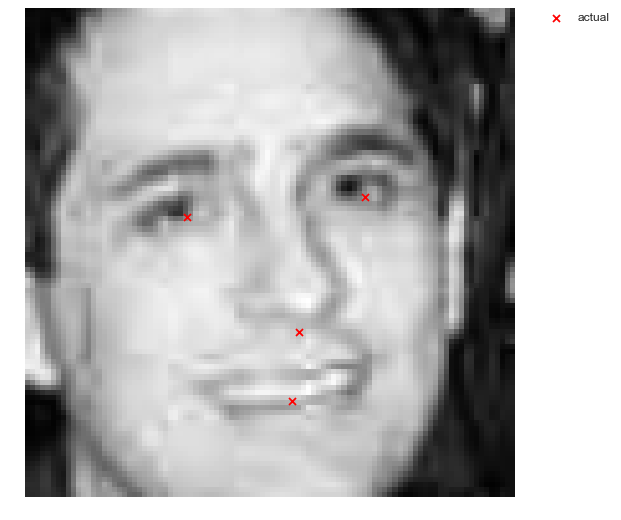

In [58]:
self.plot_example(self.train_data_n[0], self.train_labels_n[0]) # from incomplete labels

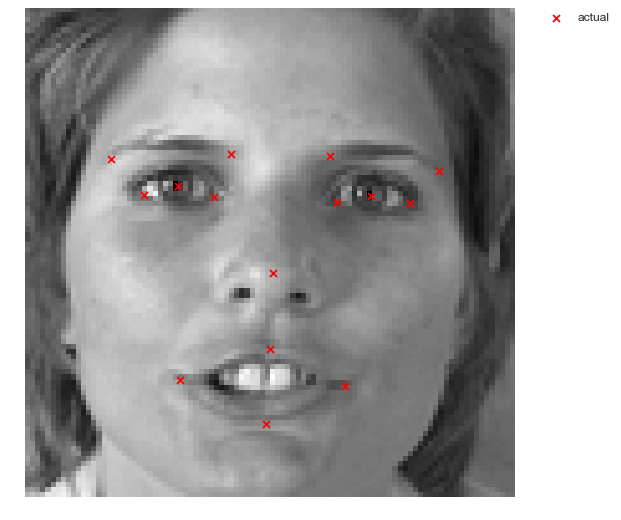

In [59]:
self.plot_example(self.train_data[25], self.train_labels[25]) # from complete labels

## K-NN

In [60]:
y_pred = self.knn.predict(self.dev_data) # this is a stored method that trains on train data then returns KNN object

In [61]:
self.score(self.dev_labels, y_pred)

2.5619188794460075

#### Using _average_nans to preprocess and create more training data

In [62]:
self.knn = self.K_nn(data=self.train_data_n, labels=self._average_nans(self.train_labels_n))

In [63]:
y_pred = self.knn.predict(self.dev_data)

In [64]:
self.score(self.dev_labels, y_pred)

1.8683700093573867

## Plot a Prediction

RMSE of 1.51943736599


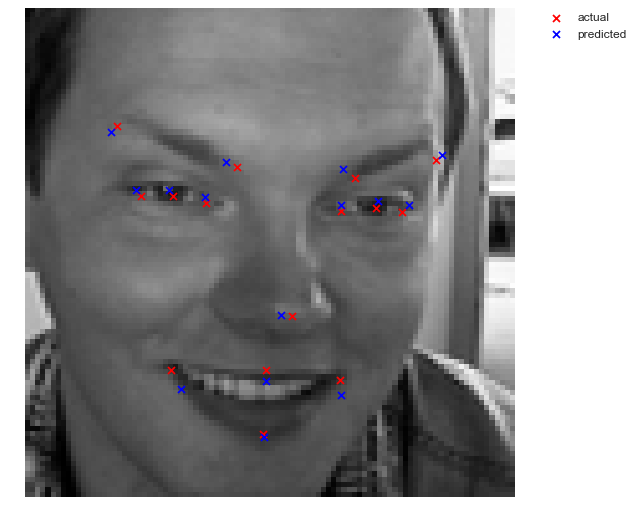

In [65]:
print ('RMSE of '+ str((self.score(self.dev_labels[25], y_pred[25]))))
self.plot_example(self.dev_data[25], self.dev_labels[25], y_pred[25])

## Logistic Regression

## Neural Net

#### Standard Scale Training and Labels

In [77]:
label_scaler = StandardScaler()
label_scaler.fit(self.train_labels)

data_scaler = StandardScaler()
data_scaler.fit(self.train_data)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [79]:
self.mlp = self.MLPRegressor(data_scaler.transform(self.train_data), label_scaler.transform(self.train_labels))

In [80]:
y_pred = self.mlp.predict(scaler.transform(self.dev_data))
self.score(self.dev_labels, label_scaler.inverse_transform(y_pred))

2.6254643072299402

## Plot a Prediction

RMSE of 2.31414834457


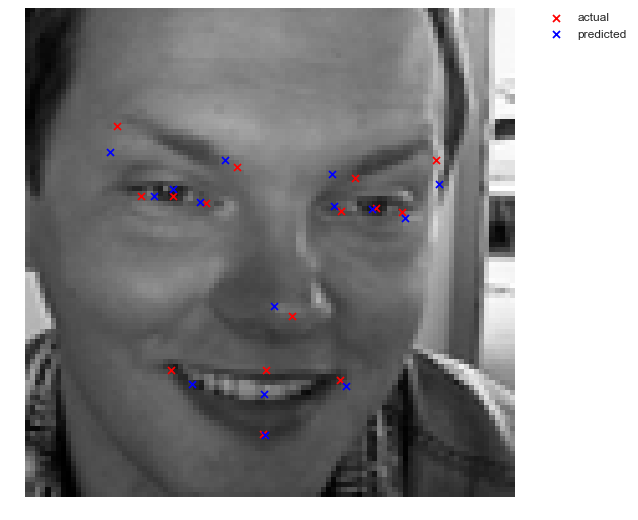

In [82]:
print ('RMSE of '+ str((self.score(self.dev_labels[25], label_scaler.inverse_transform(y_pred[25])))))
self.plot_example(self.dev_data[25], self.dev_labels[25], label_scaler.inverse_transform(y_pred[25]))

## Grid Search to Find Best Parameters

In [ ]:
knn = KNeighborsRegressor()
parameters ={'n_neighbors': range(1, 25)}
clf = GridSearchCV(knn, parameters)
clf.fit(self.train_data, self.train_labels)
clf.best_params_